In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from anndata import AnnData
# from typing import Dict
# from IPython.display import display, HTML
# from scipy.stats import hypergeom
# from pylab import rcParams

In [2]:
#Load in data
RNAseq_annD = sc.read_h5ad("combinedCells.h5ad")

In [3]:
#take a look
RNAseq_annD

AnnData object with n_obs × n_vars = 468727 × 17658
    obs: 'Id', 'sizeFactors', 'Cohort', 'ID', 'Internal_ID', 'CMC_ID', 'Phenotype', 'Batch', 'HTO', 'Gender', 'Age', 'PMI', 'EUR_Ancestry', 'EAS_Ancestry', 'AMR_Ancestry', 'SAS_Ancestry', 'AFR_Ancestry', 'Benzodiazepines', 'Anticonvulsants', 'AntipsychTyp', 'AntipsychAtyp', 'Antidepress', 'Lithium', 'PRS', 'POP.EL3SD', 'Celltype', 'Color', 'umis', 'genes', 'mito.perc', 'assigned_archetype', 'node_centrality'
    uns: 'metadata', 'obsm_annot', 'varm_annot'
    layers: 'counts'

In [19]:
RNAseq_annD.layers["counts"]

<468727x17658 sparse matrix of type '<class 'numpy.float32'>'
	with 1653140487 stored elements in Compressed Sparse Column format>

In [10]:
#filter out subjects with at least 100 cells sequenced
allID = (pd.value_counts(RNAseq_annD.obs["ID"])).index
subjectToInclude = allID[pd.value_counts(RNAseq_annD.obs["ID"]) > 100]

dataAll = RNAseq_annD.to_df().to_numpy()

In [61]:
# filtering and 
# a) summing counts of a gene across all cells of the subject and 
# b) normalizing it based on the number of cells sequenced of this subject

dataBulk = np.empty((1,17658))
Phenotype = np.array([])
genes = RNAseq_annD.obs["genes"]
for subject in subjectToInclude:
    subjectRows = dataAll[np.where(RNAseq_annD.obs["ID"] ==subject),:][0]
    subjectBulk = np.sum(subjectRows, axis = 0) / (np.shape(np.where(RNAseq_annD.obs["ID"] ==subject))[1])
    phenotypeOfSub = RNAseq_annD.obs["Phenotype"][RNAseq_annD.obs["ID"] ==subject][0]
    Phenotype = np.append(Phenotype, [phenotypeOfSub], axis = 0)
    dataBulk = np.append(dataBulk, [subjectBulk], axis = 0)
dataBulk = dataBulk[1:,:] # because the first line is all 0 from initializing the array. This way the dimension is now correct

In [63]:
# make a new annotated dataframe

filtered_annD = AnnData(dataBulk)
filtered_annD.obs["Phenotype"] = Phenotype
filtered_annD.obs["genes"] = genes

/ocean/projects/ibn200014p/bnphan/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'Phenotype' as categorical


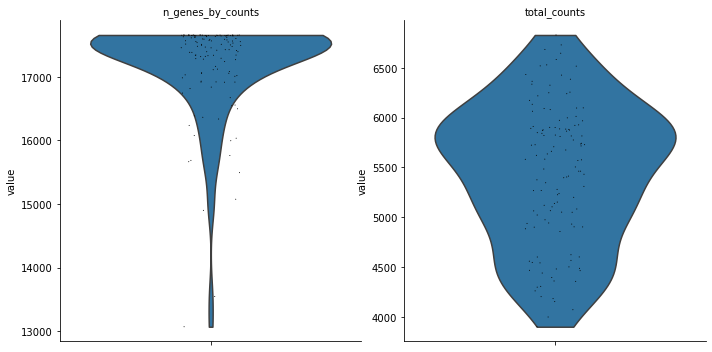

In [65]:
# take a look at qc stats
sc.pp.calculate_qc_metrics(filtered_annD, inplace= True)
sc.pl.violin(filtered_annD, ['n_genes_by_counts', 'total_counts'],
             multi_panel=True)

# this means that most people have around 17500 (almost all) genes expressed (summing across all cells)
# Most genes are expressed in around 5700 people

In [107]:
# normalize by counts per thousands
sc.pp.normalize_total(filtered_annD,target_sum=1e3)
dataBulk = filtered_annD.to_df().to_numpy()

In [67]:
geneNames = pd.read_csv("combinedCells_names.csv", header = None).to_numpy()[:,0]
# posD1 = pd.read_csv("posD1_associatedGenes.txt", sep = "\t", header = None).to_numpy()[:,0]
# posD2 = pd.read_csv("posD2_associatedGenes.txt", sep = "\t", header = None).to_numpy()[:,0]
# negD1 = pd.read_csv("negD1_associatedGenes.txt", sep = "\t", header = None).to_numpy()[:,0]
# negD2 = pd.read_csv("negD2_associatedGenes.txt", sep = "\t", header = None).to_numpy()[:,0]

In [22]:
# not all of the genes in the txt files are in geneNames
# posD1_idx = np.isin(geneNames,posD1)
# posD2_idx = np.isin(geneNames, posD2)
# negD1_idx = np.isin(geneNames, negD1)
# negD2_idx = np.isin(geneNames, negD2)

In [40]:
# posD1_dataset = data[:,posD1_idx]
# posD2_dataset = data[:,posD2_idx]
# negD1_dataset = data[:,negD1_idx]
# negD2_dataset = data[:,negD2_idx]

(100000, 312)

In [108]:
CNTN6_data = dataBulk[:,np.where(geneNames == "CNTN6")[0][0]]
LHFPL3_data = dataBulk[:,np.where(geneNames == "LHFPL3")[0][0]]
FHIT_data = dataBulk[:,np.where(geneNames == "FHIT")[0][0]]
ANKS1B_data = dataBulk[:,np.where(geneNames=="ANKS1B")[0][0]]

In [109]:
topPeaksDf = pd.DataFrame(np.transpose(np.array([CNTN6_data,LHFPL3_data,FHIT_data,ANKS1B_data,Phenotype])), columns = ["CNTN6","LHFPL3","FHIT","ANKS1B", "Phenotype"])

In [110]:
SZ_data = topPeaksDf[topPeaksDf["Phenotype"] == "SZ"]
Con_data = topPeaksDf[topPeaksDf["Phenotype"] == "CON"]

In [111]:
import scipy as sci
SZ_CNTN6 = np.array(SZ_data["CNTN6"], dtype = "float64")
Con_CNTN6 = np.array(Con_data["CNTN6"], dtype = "float64")
SZ_LHFPL3 = np.array(SZ_data["LHFPL3"], dtype = "float64")
Con_LHFPL3 = np.array(Con_data["LHFPL3"], dtype = "float64")
SZ_FHIT = np.array(SZ_data["FHIT"], dtype = "float64")
Con_FHIT = np.array(Con_data["FHIT"], dtype = "float64")
SZ_ANKS1B = np.array(SZ_data["ANKS1B"], dtype = "float64")
Con_ANKS1B = np.array(Con_data["ANKS1B"], dtype = "float64")
print(sci.stats.ttest_ind(SZ_CNTN6, Con_CNTN6).pvalue)
print(sci.stats.ttest_ind(SZ_LHFPL3,Con_LHFPL3).pvalue)
print(sci.stats.ttest_ind(SZ_FHIT,Con_FHIT).pvalue)
print(sci.stats.ttest_ind(SZ_ANKS1B,Con_ANKS1B).pvalue)

0.34153200271061224
0.4851902803954373
0.19546989682831709
0.2997229389103859
